# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.models import load_model

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
# sir uncomment it to download
# !wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/electricity.txt.gz -P /content/drive/MyDrive/data/varsity/

In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/electricity.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

# EDA

The dataset contains electricity consumption (in kWh) from 321 clients (nodes), recorded every 15 minutes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Columns: 321 entries, 0 to 320
dtypes: float64(321)
memory usage: 64.4 MB


In [ ]:
(26303*15/60)

6575.75

In [ ]:
365*24

8760

In [ ]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


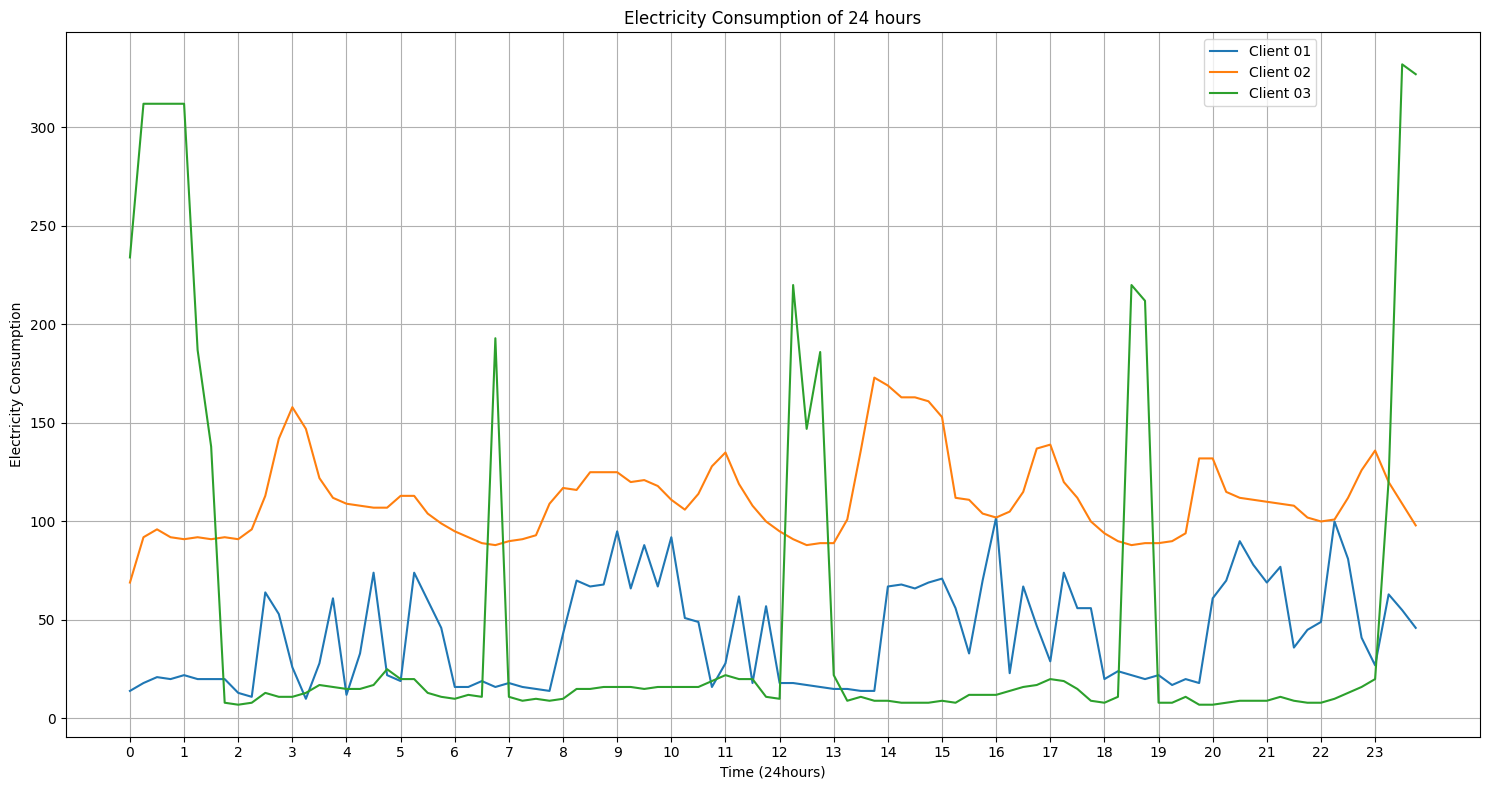

In [ ]:
# Visualizations for Electricity Dataset (15-min interval)

plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:96, 0])
plt.plot(df.iloc[:96, 1])
plt.plot(df.iloc[:96, 2])
plt.title('Electricity Consumption of 24 hours')
plt.xlabel('Time (24hours)')
plt.ylabel('Electricity Consumption')
plt.grid(True)
ticks = np.arange(0, 96, 4)  # 0,4,8,...,92
labels = np.arange(0, 24, 1)  # 0 to 23 hours
plt.xticks(ticks, labels)
plt.tight_layout()
plt.legend(['Client 01', 'Client 02', 'Client 03'],
           loc='upper left', bbox_to_anchor=(0.8, 1))
plt.show()


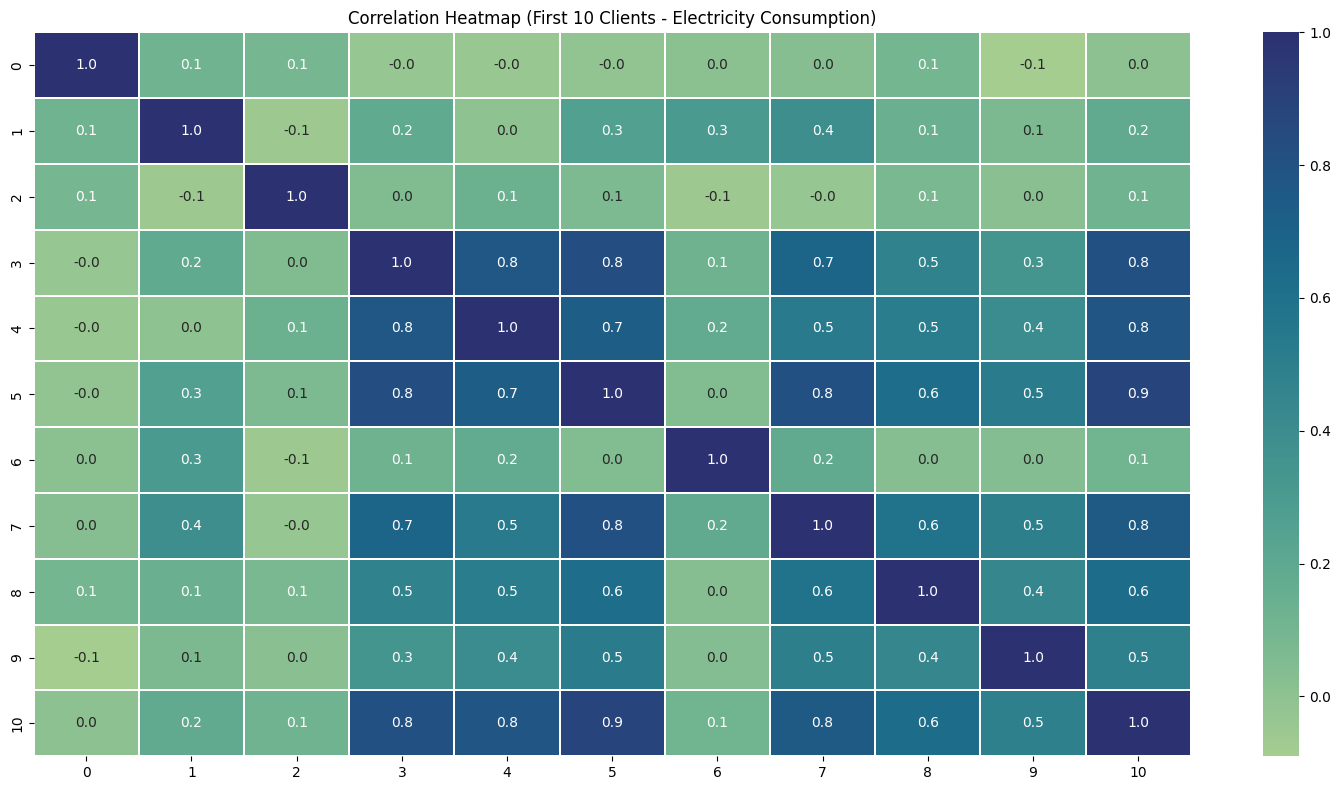

In [ ]:
correlation_subset = df.iloc[:, :11].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='crest', linewidths=0.2, fmt='.1f')
plt.title('Correlation Heatmap (First 10 Clients - Electricity Consumption)')
plt.tight_layout()
plt.show()

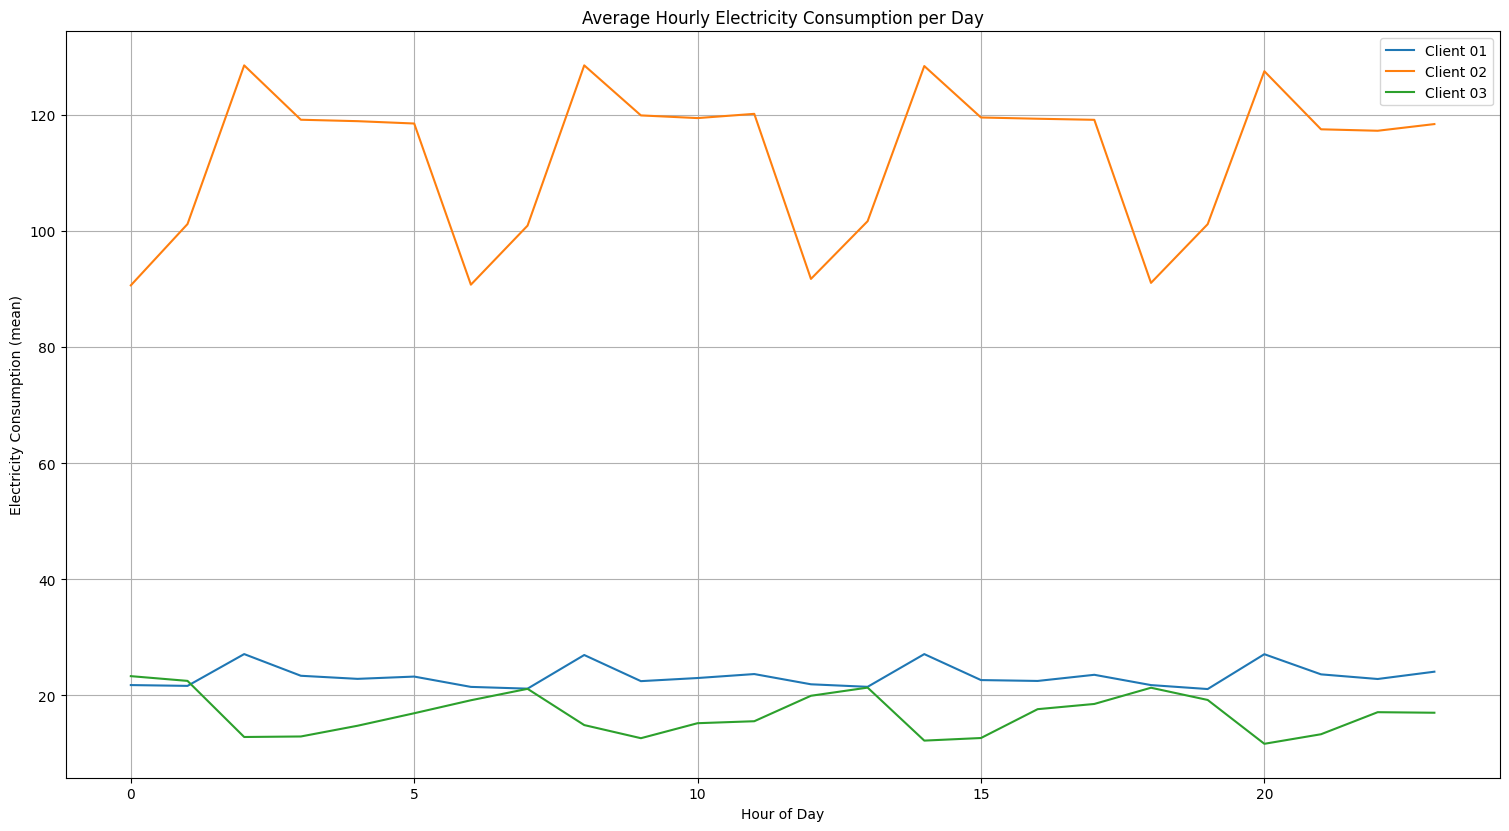

In [ ]:
# Calculate hour from index (96 steps per day, 4 steps per hour)
df['hours'] = (df.index % 96) // 4

plt.figure(figsize=(15, 8))
plt.plot(df.groupby(by='hours')[[0,1,2]].mean())
plt.grid(True)
plt.tight_layout()
plt.xlabel('Hour of Day')
plt.ylabel('Electricity Consumption (mean)')
plt.title('Average Hourly Electricity Consumption per Day')
plt.legend(['Client 01', 'Client 02', 'Client 03'])
plt.show()


In [ ]:
# Create datetime index for the dataset (15-min intervals)
date_range = pd.date_range(start='2012-01-01', periods=len(df), freq='15min')
df['month'] = date_range.month


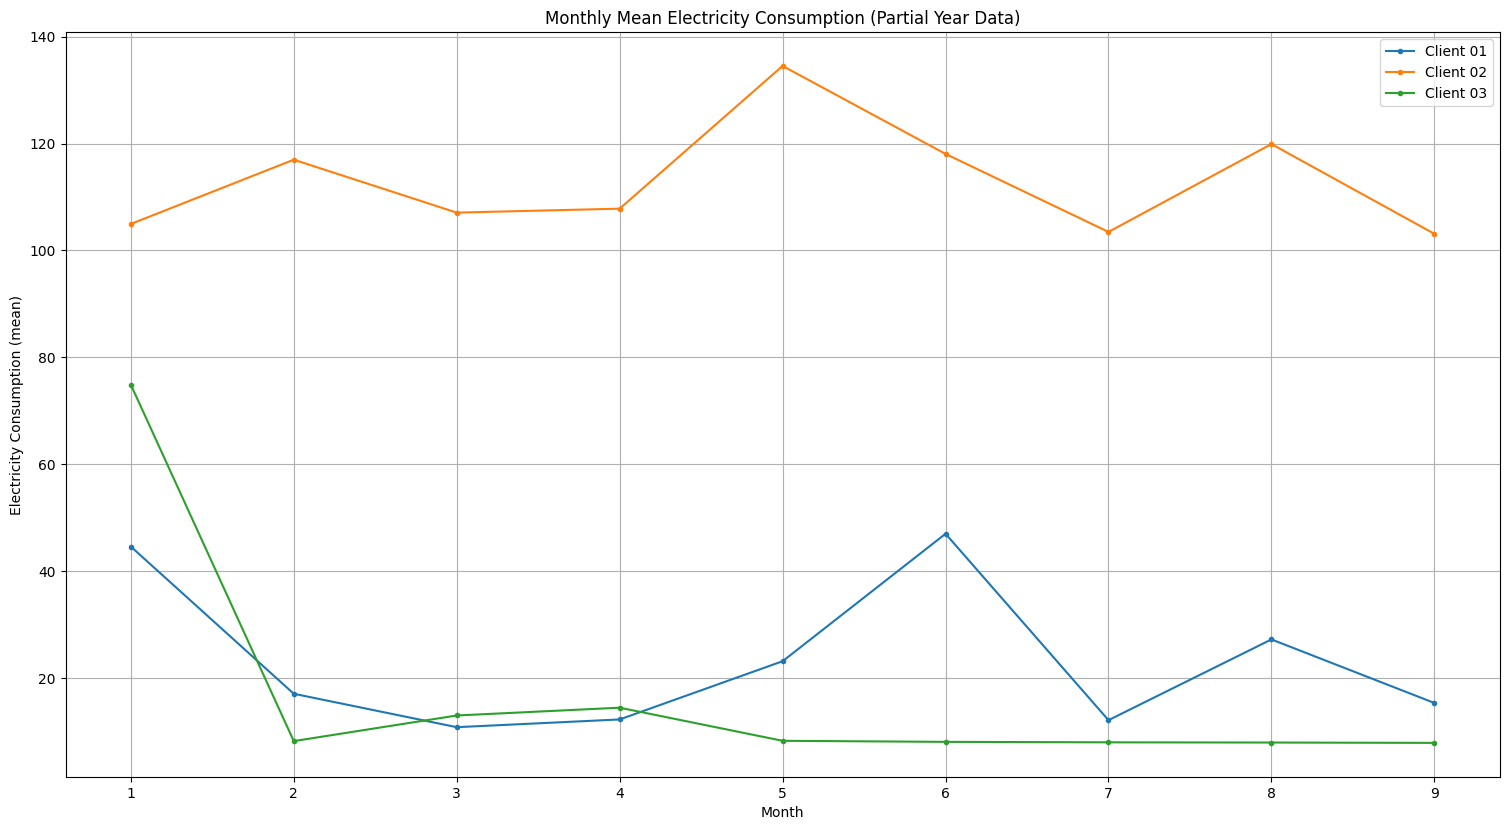

In [ ]:
monthly_avg = df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

plt.figure(figsize=(15, 8))
plt.plot(monthly_avg, marker='.')
plt.grid(True)
plt.tight_layout()
plt.xlabel('Month')
plt.ylabel('Electricity Consumption (mean)')
plt.title('Monthly Mean Electricity Consumption (Partial Year Data)')
plt.legend(['Client 01', 'Client 02', 'Client 03'])
plt.show()


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,26304.0,23.263762,24.127164,0.0,9.00,11.0,24.00,140.0
1,26304.0,112.885569,25.553141,0.0,95.00,113.0,130.00,296.0
2,26304.0,16.821624,49.190377,0.0,8.00,8.0,10.00,601.0
3,26304.0,440.335196,152.601050,0.0,334.75,400.0,511.00,1170.0
4,26304.0,200.536724,69.727348,0.0,148.00,190.0,239.00,547.0
...,...,...,...,...,...,...,...,...
318,26304.0,2264.188641,545.279372,0.0,1999.00,2319.0,2607.00,4449.0
319,26304.0,507.008858,267.445473,0.0,233.00,504.0,704.00,1369.0
320,26304.0,3335.883744,552.754335,0.0,2920.00,3271.0,3632.00,6035.0
hours,26304.0,11.500000,6.922318,0.0,5.75,11.5,17.25,23.0


In [ ]:
sample_clients = df.columns[:5]
# df[sample_clients].iloc[:500].plot(figsize=(15,6))
# plt.title('Electricity Consumption for Sample Clients (First 500 steps)')
# plt.show()


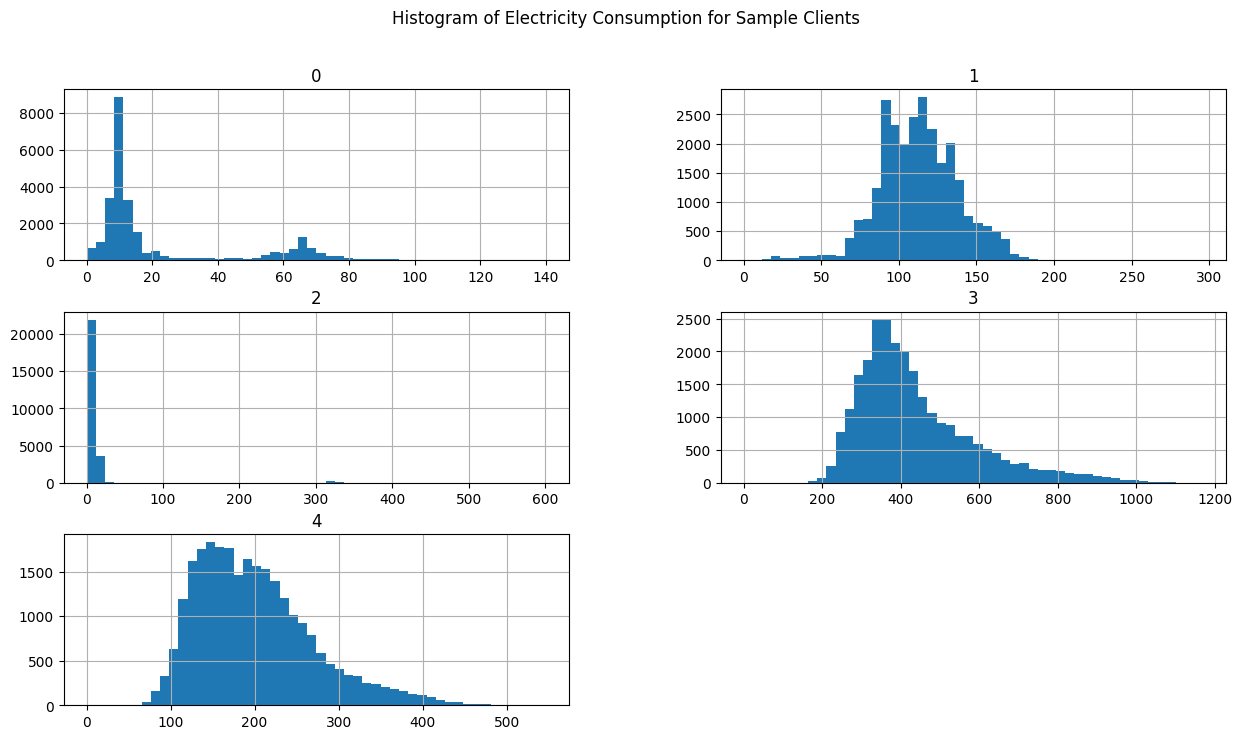

In [ ]:
df[sample_clients].hist(bins=50, figsize=(15,8))
plt.suptitle('Histogram of Electricity Consumption for Sample Clients')
plt.show()


In [ ]:
rolling_mean = df[sample_clients].rolling(window=96).mean()  # daily rolling mean
rolling_std = df[sample_clients].rolling(window=96).std()


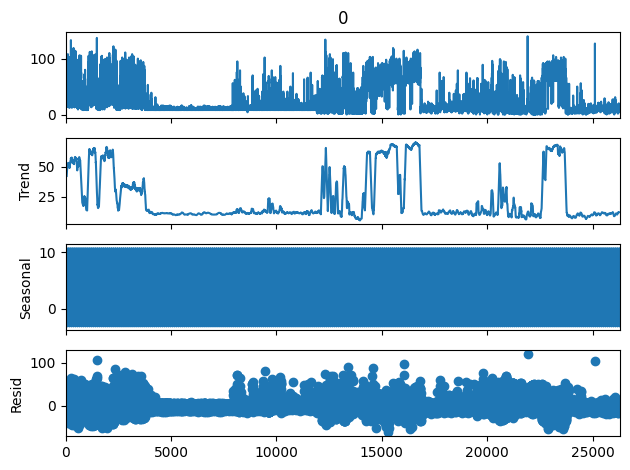

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[sample_clients[0]], model='additive', period=96)
result.plot()
plt.show()


In [ ]:
df.drop(columns=['hours', 'month'], inplace=True)

# Preprocess

In [ ]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
split_ratio = 0.8
split_idx = int(len(df_scaled) * split_ratio)
df_train = df_scaled.iloc[:split_idx]
df_test = df_scaled.iloc[split_idx:]

In [ ]:
24*60/15

96.0

In [ ]:
#########
window_size = 168
forecast_horizon = 24  # 6 hours
batch_size = 16
n_nodes = n_nodes = df_train.shape[1]

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature=(
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size)
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size)

# Model: BiLSTM Stack

In [ ]:
# BiLSTM Stack
@register_keras_serializable()
class LSTM_Model(tf.keras.Model):
    def __init__(self, n_nodes, hidden_dim=128, horizon=24, dropout_rate=0.2, bi=True, n_stack=1, norm=True, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_stack = n_stack
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.norm = norm
        self.norm1 = tf.keras.layers.LayerNormalization()

        if bi:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
          else:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
          self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
        else:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)
          else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
          self.lstm2 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.norm :
          x = self.norm1(x)
        for i in range(self.n_stack - 1):
          x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return tf.reshape(x, (-1, self.horizon, self.n_nodes))


    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "hidden_dim": self.hidden_dim,
            "horizon": self.horizon,
            "dropout_rate":self.dropout_rate,
            "bi" : self.bi,
            "n_stack":self.n_stack,
            "norm": self.norm
        })
        return config

In [ ]:
n_nodes = df_train.shape[1]
hidden_dim = 256
forecast_horizon = 24

model = LSTM_Model(n_nodes=n_nodes, hidden_dim=hidden_dim, horizon=forecast_horizon, bi=True, norm=True, n_stack=2)
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50
    654/Unknown 23s 29ms/step - loss: 0.0207 - mae: 0.0940

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


656/656 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0207 - mae: 0.0939 - val_loss: 0.0131 - val_mae: 0.0845
Epoch 2/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 0.0063 - mae: 0.0542 - val_loss: 0.0114 - val_mae: 0.0769
Epoch 3/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0058 - mae: 0.0513 - val_loss: 0.0102 - val_mae: 0.0716
Epoch 4/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0055 - mae: 0.0496 - val_loss: 0.0098 - val_mae: 0.0693
Epoch 5/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 0.0054 - mae: 0.0485 - val_loss: 0.0095 - val_mae: 0.0683
Epoch 6/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 62s 32ms/step - loss: 0.0053 - mae: 0.0480 - val_loss: 0.0093 - val_mae: 0.0674
Epoch 7/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.0053 - mae: 0.0476 - val_loss: 0.0093 - val_mae: 0.0673
Epoch 8/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 0.0052 - mae: 0.0471 - val_loss: 0.0092 - val_mae: 0.0667
Epoch 9/50
656/656 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/st

# Model: TalNet

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TalNet(tf.keras.Model):
    def __init__(self, n_nodes, horizon, n_heads=4, hidden_dim=128, dropout_rate=0.1,
                 bi=False, n_stack=1, en_norm=False, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.en_norm = en_norm

        self.norm = tf.keras.layers.LayerNormalization()

        if bi:
            self.lstm1 = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
            self.lstm2 = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(hidden_dim//2, return_sequences=False))
            self.d_model = hidden_dim * 2
        else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
            self.lstm2 = tf.keras.layers.LSTM(hidden_dim//2, return_sequences=False)
            self.d_model = hidden_dim

        self.transformer_blocks = []
        for _ in range(n_stack):
            self.transformer_blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=self.d_model),
                "attn_add": tf.keras.layers.Add(),
                "attn_norm": tf.keras.layers.LayerNormalization(),

                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(2 * self.d_model, activation='relu'),
                    tf.keras.layers.Dense(self.d_model),
                ]),
                "ffn_add": tf.keras.layers.Add(),
                "ffn_norm": tf.keras.layers.LayerNormalization()
            })

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    @tf.function
    def call(self, x):
        if self.en_norm:
            x = self.norm(x)

        x = self.lstm1(x)
        for block in self.transformer_blocks:
            attn_out = block["attn"](x, x, x)
            x = block["attn_add"]([x, attn_out])
            x = block["attn_norm"](x)

            ffn_out = block["ffn"](x)
            x = block["ffn_add"]([x, ffn_out])
            x = block["ffn_norm"](x)

        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        out = tf.reshape(x, (-1, self.horizon, self.n_nodes))
        return out

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "n_heads": self.n_heads,
            "hidden_dim": self.hidden_dim,
            "horizon": self.horizon,
            "dropout_rate": self.dropout_rate,
            "bi": self.bi,
            "n_stack": self.n_stack,
            "en_norm": self.en_norm,
        })
        return config


In [ ]:
n_nodes = df_train.shape[1]
hidden_dim = 128
forecast_horizon = 24

model = TalNet(
                n_nodes = n_nodes,
                hidden_dim = hidden_dim,
                n_heads=1,
                horizon = forecast_horizon,
                dropout_rate = 0.1,
                bi = False,
                n_stack=2,
                en_norm=False
              )

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'tal_net_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1304/1304 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - loss: 0.0303 - mae: 0.1359 - val_loss: 0.0250 - val_mae: 0.1242
Epoch 2/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 0.0135 - mae: 0.0846 - val_loss: 0.0156 - val_mae: 0.0925
Epoch 3/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 0.0075 - mae: 0.0587 - val_loss: 0.0139 - val_mae: 0.0861
Epoch 4/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 0.0069 - mae: 0.0552 - val_loss: 0.0133 - val_mae: 0.0833
Epoch 5/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 81s 35ms/step - loss: 0.0067 - mae: 0.0540 - val_loss: 0.0127 - val_mae: 0.0808
Epoch 6/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 94s 43ms/step - loss: 0.0066 - mae: 0.0533 - val_loss: 0.0123 - val_mae: 0.0790
Epoch 7/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 71s 35ms/step - loss: 0.0064 - mae: 0.0525 - val_loss: 0.0117 - val_mae: 0.0768
Epoch 8/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 83s 36ms/step - loss: 0.0062 - mae: 0.0519 - val_loss: 0.0113 - val_mae: 0.0753
Epoch 9/50
1304/1304 ━━━━━━━━━━━━━━

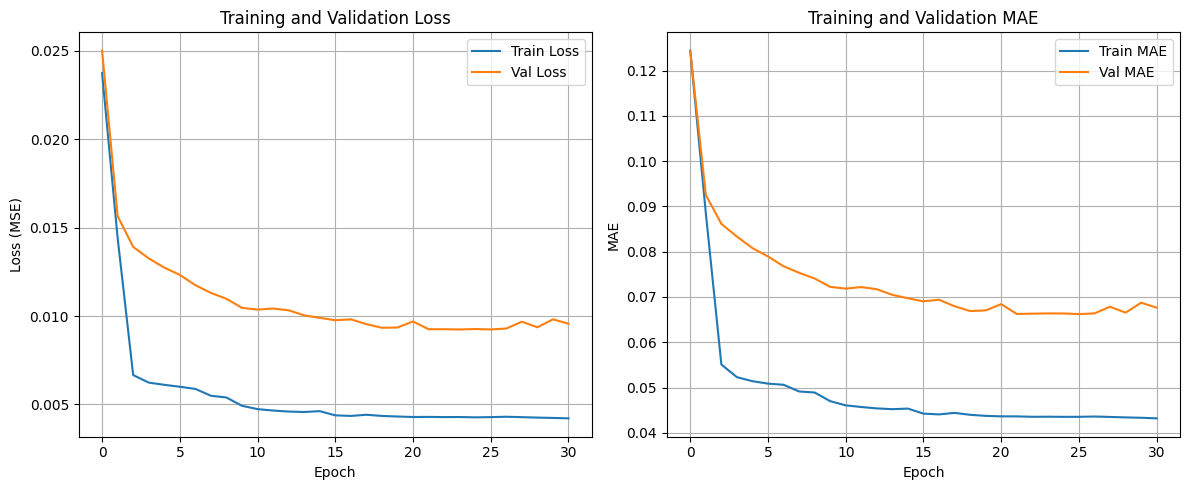

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)


# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# GCN+TalNet (high power usage: Computationally ineffective)

In [ ]:
def compute_adjacency(df, threshold=0.5):
    corr = df.corr().values
    adj = np.where(np.abs(corr) > threshold, 1.0, 0.0)
    np.fill_diagonal(adj, 0)
    return adj.astype(np.float32)

def add_adj_to_dataset(base_ds, adj_matrix):
    A_tensor = tf.convert_to_tensor(adj_matrix, dtype=tf.float32)
    def map_fn(x, y):
        A_batched = tf.tile(tf.expand_dims(A_tensor, axis=0), [tf.shape(x)[0], 1, 1])
        return (x, A_batched), y
    return base_ds.map(map_fn)

In [ ]:
A_train = compute_adjacency(df_train)
A_test = compute_adjacency(df_test)
train_ds = add_adj_to_dataset(train_dataset, A_train)
test_ds = add_adj_to_dataset(test_dataset, A_test)

In [ ]:
import tensorflow as tf

# ----------- GCN LAYER -------------
@tf.keras.utils.register_keras_serializable()
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, out_features):
        super().__init__()
        self.out_features = out_features
        self.linear = None  # Will be initialized in build()

    def build(self, input_shape):
        # input_shape: (B, T, N, D)
        _, _, _, d_in = input_shape
        self.linear = tf.keras.layers.Dense(self.out_features)
        super().build(input_shape)

    def call(self, X, A):
        # X: (B, T, N, D), A: (B, N, N)
        B, T, N, D = tf.shape(X)[0], tf.shape(X)[1], tf.shape(X)[2], tf.shape(X)[3]

        # A_hat = A + I
        A_hat = A + tf.eye(N, batch_shape=[B])

        # Degree matrix
        D_hat = tf.reduce_sum(A_hat, axis=-1)
        D_inv_sqrt = tf.linalg.diag(1.0 / tf.sqrt(D_hat + 1e-6))

        # A_norm = D^(-1/2) * A_hat * D^(-1/2)
        A_norm = tf.matmul(tf.matmul(D_inv_sqrt, A_hat), D_inv_sqrt)

        # Reshape X for batched matmul
        X_reshaped = tf.reshape(X, [B * T, N, D])
        A_tiled = tf.repeat(A_norm, repeats=T, axis=0)  # (B*T, N, N)

        # GCN computation
        out = tf.matmul(A_tiled, X_reshaped)  # (B*T, N, D)
        out = self.linear(out)  # (B*T, N, out_features)
        out = tf.reshape(out, [B, T, N, self.out_features])
        return out


# ----------- SPATIO-TEMPORAL TALNET -------------
@tf.keras.utils.register_keras_serializable()
class ST_TalNet(tf.keras.Model):
    def __init__(self, n_nodes, horizon, n_heads=4, hidden_dim=128, dropout_rate=0.1,
                 bi=False, n_stack=1, en_norm=False, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.en_norm = en_norm

        self.norm = tf.keras.layers.LayerNormalization()

        if bi:
            self.lstm1 = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
            self.lstm2 = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False))
            self.d_model = hidden_dim * 2
        else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
            self.lstm2 = tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False)
            self.d_model = hidden_dim

        self.gcn = GCNLayer(out_features=self.d_model)

        self.transformer_blocks = []
        for _ in range(n_stack):
            self.transformer_blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=self.d_model),
                "attn_add": tf.keras.layers.Add(),
                "attn_norm": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(2 * self.d_model, activation='relu'),
                    tf.keras.layers.Dense(self.d_model),
                ]),
                "ffn_add": tf.keras.layers.Add(),
                "ffn_norm": tf.keras.layers.LayerNormalization()
            })

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, inputs):
        x, A = inputs  # x: (B, T, N), A: (B, N, N)

        if self.en_norm:
            x = self.norm(x)

        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        N = self.n_nodes  # x.shape[2]

        # ---- Step 1: Reshape for LSTM ----
        x = tf.reshape(x, [B * N, T, 1])           # (B*N, T, 1)
        x = self.lstm1(x)                          # (B*N, T, d_model)
        x = tf.reshape(x, [B, N, T, self.d_model]) # (B, N, T, d_model)
        x = tf.transpose(x, [0, 2, 1, 3])          # (B, T, N, d_model)

        # ---- Step 2: GCN Layer ----
        x = self.gcn(x, A)                         # (B, T, N, d_model)

        # ---- Step 3: Flatten for Transformer ----
        x = tf.reshape(x, [B, T * N, self.d_model])

        # ---- Step 4: Transformer Blocks ----
        for block in self.transformer_blocks:
            attn_out = block["attn"](x, x, x)        # (B, T*N, d_model)
            x = block["attn_add"]([x, attn_out])     # (B, T*N, d_model)
            x = block["attn_norm"](x)

            ffn_out = block["ffn"](x)                # (B, T*N, d_model)
            x = block["ffn_add"]([x, ffn_out])
            x = block["ffn_norm"](x)

        # ---- Step 5: Final LSTM + Dense ----
        x = self.lstm2(x)  # (B, d_model//2)
        x = self.dropout(x)
        x = self.fc(x)     # (B, horizon * N)
        out = tf.reshape(x, [B, self.horizon, self.n_nodes])  # (B, H, N)
        return out


In [ ]:
model = ST_TalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    n_heads=4,
    hidden_dim=128,
    dropout_rate=0.3,
    bi=False,
    n_stack=1,
    en_norm=False
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stopping]
)


# Patched TALnet: TalNetV2

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TalNetV2(tf.keras.Model):
    def __init__(self, n_nodes, horizon, n_heads=4, hidden_dim=128, dropout_rate=0.1,
                 bi=False, n_stack=1, en_norm=False, node_emb_dim=16, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.en_norm = en_norm
        self.node_emb_dim = node_emb_dim

        self.node_embedding = tf.keras.layers.Embedding(input_dim=n_nodes, output_dim=node_emb_dim)
        self.norm = tf.keras.layers.LayerNormalization()
        self.temporal_conv = tf.keras.layers.Conv1D(
                                                    filters=hidden_dim, kernel_size=3,
                                                    padding='causal', activation='relu'
                                                    )

        if bi:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
            self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False))
            self.d_model = hidden_dim * 2
        else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
            self.lstm2 = tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False)
            self.d_model = hidden_dim

        self.transformer_blocks = []
        for _ in range(n_stack):
            self.transformer_blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=self.d_model),
                "attn_add": tf.keras.layers.Add(),
                "attn_norm": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(2 * self.d_model, activation='relu'),
                    tf.keras.layers.Dense(self.d_model),
                ]),
                "ffn_add": tf.keras.layers.Add(),
                "ffn_norm": tf.keras.layers.LayerNormalization()
            })

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.en_norm:
            x = self.norm(x)

        batch_size = tf.shape(x)[0]
        time_steps = tf.shape(x)[1]

        node_ids = tf.range(self.n_nodes)
        node_emb = self.node_embedding(node_ids)
        node_emb_exp = tf.expand_dims(node_emb, 0)
        node_emb_exp = tf.expand_dims(node_emb_exp, 0)
        node_emb_tiled = tf.tile(node_emb_exp, [batch_size, time_steps, 1, 1])

        x_exp = tf.expand_dims(x, -1)
        x_concat = tf.concat([x_exp, node_emb_tiled], axis=-1)

        x_reshaped = tf.reshape(x_concat, [batch_size * self.n_nodes, time_steps, 1 + self.node_emb_dim])
        x_conv = self.temporal_conv(x_reshaped)
        x_conv_reshaped = tf.reshape(x_conv, [batch_size, time_steps, self.n_nodes, self.hidden_dim])
        x_for_lstm = tf.reshape(x_conv_reshaped, [batch_size, time_steps, self.n_nodes * self.hidden_dim])

        x_lstm1 = self.lstm1(x_for_lstm)

        x = x_lstm1
        for block in self.transformer_blocks:
            attn_out = block["attn"](x, x, x)
            x = block["attn_add"]([x, attn_out])
            x = block["attn_norm"](x)

            ffn_out = block["ffn"](x)
            x = block["ffn_add"]([x, ffn_out])
            x = block["ffn_norm"](x)

        x_lstm2 = self.lstm2(x)
        x_drop = self.dropout(x_lstm2)
        x_out = self.fc(x_drop)
        out = tf.reshape(x_out, [batch_size, self.horizon, self.n_nodes])

        return out


In [ ]:
model = TalNetV2(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    n_heads=6,
    hidden_dim=32,
    dropout_rate=0.1,
    bi=True,
    n_stack=1,
    en_norm=False,
    node_emb_dim=8
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'tal_net_v2_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


   1303/Unknown 98s 70ms/step - loss: 0.0313 - mae: 0.1309

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1304/1304 ━━━━━━━━━━━━━━━━━━━━ 108s 77ms/step - loss: 0.0312 - mae: 0.1308 - val_loss: 0.0146 - val_mae: 0.0897
Epoch 2/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 101s 77ms/step - loss: 0.0070 - mae: 0.0555 - val_loss: 0.0137 - val_mae: 0.0861
Epoch 3/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - loss: 0.0064 - mae: 0.0526 - val_loss: 0.0119 - val_mae: 0.0785
Epoch 4/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 101s 77ms/step - loss: 0.0055 - mae: 0.0494 - val_loss: 0.0111 - val_mae: 0.0750
Epoch 5/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 142s 109ms/step - loss: 0.0051 - mae: 0.0474 - val_loss: 0.0105 - val_mae: 0.0720
Epoch 6/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 100s 77ms/step - loss: 0.0049 - mae: 0.0463 - val_loss: 0.0101 - val_mae: 0.0706
Epoch 7/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 100s 77ms/step - loss: 0.0048 - mae: 0.0455 - val_loss: 0.0096 - val_mae: 0.0684
Epoch 8/50
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 101s 77ms/step - loss: 0.0047 - mae: 0.0453 - val_loss: 0.0099 - val_mae: 0.0698
Epoch 9/50
1304/1304 ━━━━

Note: Tried higher number of attention head, with lower hidden dim which is working very fine...maye possible to get more improvemnet on more epochs.
Noted drastically stabilization in the model training after lots of epoch

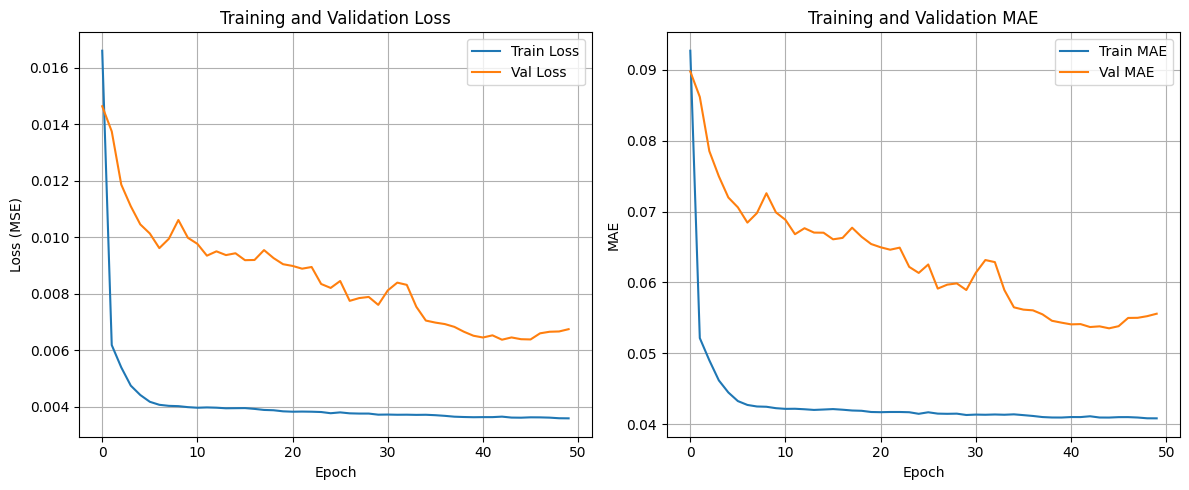

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }

In [ ]:
# Collect y_test from the test_dataset
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)


In [ ]:
y_pred = model.predict(test_dataset)

317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
print(f'Model Name: Stacked BiLSTM')
for step in [3, 6, 12, 24]:
    rse, corr = step_rse_corr(y_test, y_pred, step)
    print(f"Step {str(step):3s}--> RSE={rse:.4f}, CORR={corr:.4f}")

In [ ]:
print(f'Model Name: TALnet')
for step in [3, 6, 12, 24]:
    rse, corr = step_rse_corr(y_test, y_pred, step)
    print(f"Step {str(step):3s}--> RSE={rse:.4f}, CORR={corr:.4f}")

Model Name: TALnet
Step 3  --> RSE=0.4770, CORR=0.8925
Step 6  --> RSE=0.4774, CORR=0.8921
Step 12 --> RSE=0.4831, CORR=0.8914
Step 24 --> RSE=0.4905, CORR=0.8891


In [ ]:
print(f'Model Name: TalNetV2')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: TalNetV2
Step  3 --> R²=0.8409, RMSE=0.0782, MAE=0.0525, MSE=0.0061, SMAPE=17.33%, RSE=0.3989, CORR=0.9182
Step  6 --> R²=0.8385, RMSE=0.0788, MAE=0.0529, MSE=0.0062, SMAPE=17.45%, RSE=0.4018, CORR=0.9171
Step 12 --> R²=0.8371, RMSE=0.0791, MAE=0.0530, MSE=0.0063, SMAPE=17.49%, RSE=0.4036, CORR=0.9167
Step 24 --> R²=0.8335, RMSE=0.0800, MAE=0.0535, MSE=0.0064, SMAPE=17.63%, RSE=0.4081, CORR=0.9153


In [ ]:
# model.save('/content/drive/MyDrive/data/varsity/electricity_biLSTM.keras')

In [ ]:
# model = load_model(
#     '/content/drive/MyDrive/data/varsity/electricity_biLSTM.keras',
#     custom_objects={'LSTM_Model': LSTM_Model}
# )


In [ ]:
model.save('/content/drive/MyDrive/data/varsity/TALnetv2_electricity.keras')